In [52]:
import requests
import pandas as pd
import numpy as np
import pickle
import pmdarima as pm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def encode_query(queryDate=None, queryHour=None):
    if queryDate is None:
        queryTimestamp = pd.Timestamp.now()
        queryTimestamp = queryTimestamp.tz_localize(None)
    else:
        queryDateTime = queryDate +' '+ queryHour
        queryTimestamp = pd.Timestamp(queryDateTime,freq='h')
    return queryTimestamp

def get_timestamps_training_data(queryTimestamp, timespan=24*7*4*2, unit='h'):
        nowTimestamp = pd.Timestamp.now()
        nowTimestamp = nowTimestamp.tz_localize(None)
        if (queryTimestamp < nowTimestamp):
            startTimestamp=queryTimestamp-pd.to_timedelta(timespan,unit=unit)
            endTimestamp=queryTimestamp-pd.to_timedelta(1,unit=unit)
        else:
            startTimestamp=nowTimestamp-pd.to_timedelta(timespan,unit=unit)
            endTimestamp=nowTimestamp-pd.to_timedelta(1,unit=unit)
        startTimestamp = startTimestamp.tz_localize(None)
        endTimestamp = endTimestamp.tz_localize(None)
        return startTimestamp, endTimestamp

def get_spot_market_training_data(startTimestamp, endTimestamp, tokenfile="ami/spotcasting/montel_bearer.json"):
    r = requests.get('https://coop.eikon.tum.de/mbt/mbt.json')
    token_data = r.json()
    startDateTime=startTimestamp.strftime('%Y-%m-%d')
    endDateTime=endTimestamp.strftime('%Y-%m-%d')

    url = 'http://api.montelnews.com/spot/getprices'
    headers = {"Authorization": "Bearer " + token_data['access_token'] }
    params = {'spotKey': '14',
            'fields': ['Base', 'Peak','Hours'],
            'fromDate': startDateTime ,
            'toDate': endDateTime,
            'currency': 'eur',
            'sortType': 'Ascending'}
    response = requests.get(url, headers=headers, params=params)

def get_top_feature_names():
    feature_names = [
            'value__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)',
            'value__root_mean_square',
            'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0',
            'value__energy_ratio_by_chunks__num_segments_10__segment_focus_9',
            'value__mean_second_derivative_central',
            'value__fft_coefficient__attr_"imag"__coeff_3',
            'value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)',
            'value__quantile__q_0.8', 'value__index_mass_quantile__q_0.9',
            'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0',
            'value__mean_change', 'value__fft_coefficient__attr_"real"__coeff_8',
            'value__fft_coefficient__attr_"real"__coeff_9',
            'value__fft_aggregated__aggtype_"centroid"',
            'value__fft_coefficient__attr_"real"__coeff_10',
            'value__fft_coefficient__attr_"real"__coeff_12',
            'value__fft_coefficient__attr_"real"__coeff_11'
        ]
    return feature_names

def get_exogenous_features(queryTimestamp, prediction_length, features, label, reference_label):
    
    curr_time = pd.Timestamp('2021-07-03 00:00:00')
    # get date indeces
    train_start, train_end = get_timestamps_training_data(queryTimestamp)
    test_end = train_end + pd.to_timedelta(prediction_length-1,unit='h')

    # get label
    # label = get_spot_market_training_data(train_start, train_end)
    label = label[train_start:train_end]

    # get mask
    date_range = pd.date_range(start=train_start,end=test_end,freq='h')
    normal_mask = (date_range >= reference_label.index[0]) & (date_range <= reference_label.index[-1]) # label + features
    # match_feature_mask = (date_range <= pd.Timestamp.now()) & ((date_range < reference_label.index[0])|(date_range > reference_label.index[-1]))
    # predict_feature_mask = date_range > pd.Timestamp.now()
    match_feature_mask = (date_range < curr_time) & ((date_range < reference_label.index[0])|(date_range > reference_label.index[-1]))
    predict_feature_mask = date_range >= curr_time
    # get the features
    feature_names = get_top_feature_names()
    # normal (we have corresponding features in cache)
    total_features = pd.DataFrame(columns=feature_names,index=date_range)
    total_features[normal_mask] = np.array(features.loc[date_range[normal_mask]])

    # match features (we have label data, we can find approximate feature part using spot price)
    target_label = label.loc[date_range[match_feature_mask]]
    best_mae = float('inf')
    best_index = 0
    for index in reference_label.loc['2021-05-01 00:00:00':].index:
        ref_label = reference_label[index:index+pd.Timedelta(len(target_label)-1, unit='h')]
        if len(ref_label) == len(target_label):
            mae = sum(abs(np.array(ref_label.value) - np.array(target_label.value)))
            if mae < best_mae:
                best_mae = mae
                best_index = index
        else:
            break
    total_features[match_feature_mask] = np.array(features[best_index:best_index+pd.Timedelta(len(target_label)-1, unit='h')])

    # predict features (we do not have label and feature, we need to predict features)
    total_features[predict_feature_mask] = np.array(total_features[curr_time-pd.Timedelta(predict_feature_mask.sum(), unit='h'):curr_time-pd.Timedelta('1h')])

    # split
    train_features = total_features[train_start:train_end]
    test_features = total_features[train_end:test_end]

    return label, train_features, test_features

def AMI_ARIMA(train_label, train_features, test_features):
    model = pm.ARIMA(order=(2,1,2))
    train_X = StandardScaler().fit_transform(np.array(train_features))
    test_X = StandardScaler().fit_transform(np.array(test_features))
    model.fit(train_label, X=train_X)
    predict_values = model.predict(n_periods=len(test_X), X=test_X)
    predict_values = pd.DataFrame(predict_values, index=test_features.index)
    return predict_values

def Visualization(train_label, predict_values, label):
    _, ax = plt.subplots(1,1,figsize=(12,8))
    train_label.iloc[-24*7:].plot(ax=ax)
    test_label = label.loc[predict_values.index]
    test_label.plot(ax=ax)
    predict_values.plot(ax=ax)
    ax.legend(['actual spot price', 'real test spot price', 'predicted spot price'])


In [53]:
# get from user
queryDate = '2021-07-15'
queryHour='00'
prediction_length = 24

# data in server
# with open('ARIMA.pkl', 'rb') as pkl:
#     model = pickle.load(pkl)
label = pd.read_pickle('label.pkl')
reference_label = label

features = pd.read_pickle('2021_features.pkl')
feature_names = get_top_feature_names()
features = features[feature_names]



C:\Users\ZYH7ABT\AppData\Local\conda\conda\envs\machineL\Lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


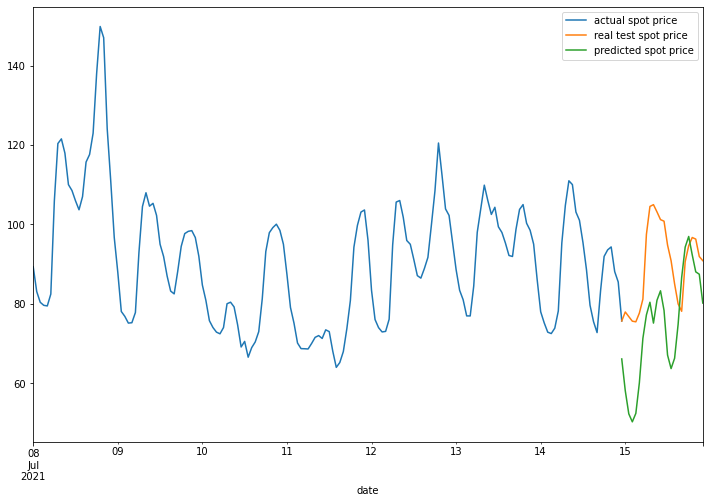

In [54]:
queryTimestamp = encode_query(queryDate=queryDate, queryHour=queryHour)
train_label, train_features, test_features = get_exogenous_features(queryTimestamp, prediction_length, features, label, reference_label)
predict_values = AMI_ARIMA(train_label, train_features, test_features)
Visualization(train_label, predict_values, label)